__The Project__

This is a guided project provided by StrataScratch. The main goal of this project is for me to learn the steps involved in a complete Data Science Project.
By the end of this project I have become more familiar with:

- data preparation for modelling
- dealing with collinear features
- feature engineering

# DoorDash Delivery Duration Prediction

<center><img src="images/doordash-logo.png" width="200"></center>
<center><img src="images/StrataScratchLogo.png" width="200"></center>

### __Data Description__

The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

#### __Columns in historical_data.csv__

_Time features_

> - market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
> - created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
> - actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

_Store features_

> - store_id: an id representing the restaurant the order was submitted for
> - store_primary_category: cuisine category of the restaurant, e.g., italian, asian
> - order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

_Order features_

> - total_items: total number of items in the order
> - subtotal: total value of the order submitted (in cents)
> - num_distinct_items: number of distinct items included in the order
> - min_item_price: price of the item with the least cost in the order (in cents)
> - max_item_price: price of the item with the highest cost in the order (in cents)

_Market features_

> DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

> - total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
> - total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order
> - total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

_Predictions from other models_

> We have predictions from other models for various stages of delivery process that we can use:

- estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
- estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

#### __Practicalities__
>Build a model to predict the total delivery duration seconds (as defined above). Feel free to generate additional features from the given data to improve model performance. Explain:

- model(s) used, how you evaluated your model performance on the historical data,
- any data processing you performed on the data,
- feature engineering choices you made,
- other information you would like to share your modeling approach.




## Data Exploration
#### Import Libraries
Let’s first import the libraries. We will do data manipulation and work with arrays, that’s why we load pandas and NumPy. Also, we will draw a graph by using matplotlib and seaborn.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Read and View Data
Here we will read our data from the CSV file and then we will look at the first rows of our data.

In [2]:
df = pd.read_csv('datasets/historical_data.csv')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


### Data Exploration
After that, let’s use the info function to see the datatypes, lengths, and memory usage of our data frame.

here is our dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

Here we can see the differences between the shapes of our features. That means we have a lot of missing & na values. Also, if we use categorical data in our model, we should turn them into dummy variables because machine learning models accept numerical data. Yet, variables like market_id are not effective for us, so that they can be removed.



#### Format Your Columns
We will do calculations by using the DateTime data type. To do that, we should convert our columns format. So we will use the datetime library. First, we will import the datetime library and use the to_datetime() function to change the created_at column and actual_delivery_time.

TARGET VARIABLE = ACTUAL DELIVERY TIME - ORDER CREATION TIME

In [4]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])



In [5]:
# check feature data type has been changed from object to datetime
df.dtypes

market_id                                              float64
created_at                                      datetime64[ns]
actual_delivery_time                            datetime64[ns]
store_id                                                 int64
store_primary_category                                  object
order_protocol                                         float64
total_items                                              int64
subtotal                                                 int64
num_distinct_items                                       int64
min_item_price                                           int64
max_item_price                                           int64
total_onshift_dashers                                  float64
total_busy_dashers                                     float64
total_outstanding_orders                               float64
estimated_order_place_duration                           int64
estimated_store_to_consumer_driving_duration           

Let us create new features from the existing features. From the existing features we can calculate for:

- Actual delivery duration
- Dashers ratio
- Estimated non-prep duration

#### Create New Features
We do not have a variable that the problem wants us to create, so we should calculate it by using our features. Here, we will create three different features, one of them is our target variable, which is the actual total delivery duration. Let’s do it.

#### Actual Total Delivery Duration - TARGET VARIABLE
We will subtract created_at from the actual_delivery_time to find the actual total delivery duration. After that, we will transform it into seconds by using the total_seconds() function. Let’s do it and look first rows of our data frame.

In [6]:
# creating target variable
from datetime import datetime
df['actual_total_delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


#### Busy_dashers_ratio - CREATE NEW VARIABLE
To make the comparison more meaningful, we will create a new variable called 'busy_dashers_ratio'. This variable will represent the proportion of busy dashers when an order was placed, expressed as a percentage of the total number of dashers working the shift at that time.

In [7]:
df['busy_dashers_ratio'] = df['total_busy_dashers']/ df['total_onshift_dashers']

#### Estimated Non-Prep Duration
Alright, we can think of the delivery process by splitting it into two subsections preparation and non-preparation time. We will add estimated_store_to_customer_driving_duration to estimated_order_place_duration. Let’s do it with the following code and look first rows of our data frame.

In [8]:
df['estimated_non_prep_duration'] = df['estimated_store_to_consumer_driving_duration'] + df['estimated_order_place_duration']

<p align="center" width="100%">
   <img src="images/non-prep-duation.png" width="300">
</p>

### Data Preparation

***Let us deal with nominal values in our data by one-hot encoding. But first, we will check what columns can we encode to create new dummy variables.***


In this step, we will prepare our data for building a machine-learning model in the next stages. To do that, let’s look at three categorical columns to decide whether we will turn these into numbers.

In [9]:
df['market_id'].nunique()

6

In [10]:
df['store_id'].nunique()

6743

In [11]:
df['order_protocol'].nunique()

7

Our code outputs 6, 6743, and 7, respectively. Store id columns have too many (6743) different options, so we remove that option. Yet, market_id and order_id can turn into numerical variables.

Here we will first find a unique store id and assign them to store_id_unique and then find the most frequent category in the second step.

Imputation

Another feature that we will use for the prediction is the primary category for each store. But since we have null values, we need to impute them by using the mode of the category for each store.

Here we will first find a unique store id and assign them to store_id_unique and then find the most frequent category in the second step.

In [12]:
# create dictionary with most repeated categories of each store to fill null rows where it is possible
store_id_unique = df['store_id'].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode() for store_id in store_id_unique}

Then we will use a custom function to fill these values into our data frame by using it with the apply method afterward.

In [13]:
def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# fill null values
df['nan_free_store_primary_category'] = df.store_id.apply(fill)

Alright, now our categorical variable is ready to be turned into numerical by using the get_dummies pandas function.



### Dummy Variables
Here, we will create dummy variables for order_protocol and market_id and view the first rows of the data frame.

It makes sense to create a dummy variable for market_id and order_protocol but not on the store_id because of the amount of unique values that we have.

In [14]:
order_protocol_dummies = pd.get_dummies(df.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,True,False,False,False,False,False,False
1,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [15]:
market_id_dummies = pd.get_dummies(df.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,False,True,False,False,False


In [16]:
store_primary_category_dummies = pd.get_dummies(df.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Data Frame Restructuring
At this stage, let’s restructure our data frame by removing the original columns and replacing them with the dummies variable by using the concat() function.

Training Dataset

We are going to remove columns which we used to make other features and those that we have made a dummy variable.

In [17]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, nan_free_store_primary_category, actual_delivery_duration
train_df = df.drop(columns=["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", "nan_free_store_primary_category"])
train_df.head()

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [18]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
train_df = train_df.astype('float32')
train_df.head()

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since we have 100 columns, it might be hard to grasp them just by looking into the first rows of our DataFrame, so you can dig deeper by using different statistical functions.

In [19]:
train_df.describe()

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,2.882352,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,1.503771,2.666546,1823.093750,1.630255,522.038635,558.411377,34.526787,32.145733,52.661831,90.139648,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
train_df['busy_dashers_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

Check infinity values

Here, we can see the inf values. They happen because we calculated the busy dasher's ratio by doing the dividing operation. And if you divide some number by zero, the output will be inf if your number is positive. If your number is negative, then it will be -inf.

So to get rid of such values, we will use three different functions that aim to find inf values in our DataFrame.

In [21]:
# check infinity values using numpy infinite() function *nested function
    # x = ~np.isfinite(train_df) # check all records on all columns for non finite values
    # y = np.any(x,axis=0) # check if any of the series/columns from variable x contains True values, will return columns with True or False value
    # z = np.where(y==True)

np.where(np.any(~np.isfinite(train_df),axis=0)==True)

(array([ 0,  6,  7,  8, 10, 11, 12, 13]),)

Now we can replace these inf values with the NaN values and drop them. Let’s look at the shape of our DataFrame to see how many rows are left.

In [22]:
#replace inf
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
#drop all nans
train_df.dropna(inplace=True)

In [23]:
train_df.shape

(176166, 101)

As you can see, in the beginning, some of our columns had up to 197428 rows. It looks like we removed 20.358 rows along the way of the data preparation for modeling.

Now, let’s double-check whether or not our DataFrame still contains missing values.

In [24]:
train_df.isna().sum().sum()

0

Alright, it looks like we removed all NAs successfully.

## Part 2: Collinearity and Removing Redundancies

Here, we will focus on collinearity and removing it, like drawing a heatmap and writing a custom function after.


Collinearity occurs when two or more predictor variables in a regression model are highly correlated with each other. This can lead to problems in interpreting the results of the model, as the coefficients of the correlated variables may be unstable and difficult to interpret.

In addition, collinearity can affect the model’s predictive power, as it can reduce the variance of the coefficients and increase the standard errors. This leads to a decrease in the overall model accuracy.

To address collinearity, one approach is to reduce the dimensionality of the data by selecting a subset of variables that are not highly correlated with each other. One way to do this is by using a correlation matrix, which shows the correlation between all pairs of variables in the DataFrame. Also, a heatmap can be used to visualize the correlations and a mask can be used to identify variables that are highly correlated and may need to be removed from the model.

Other approaches to addressing collinearity are using regularization techniques such as Ridge or Lasso regression or using principal component analysis, which we will go through in Part 3.

In this data project we will use the diagonal heatmap.

### Diagonal Heatmap
We will apply the mask to our heatmap to slice it diagonally after we draw it. To create a mask, we will create an array filled with ones.  We will then assign the upper side of the array a value of 1 and the lower side a value of 0, and apply the mask by setting all values to 1. Once the mask has been created, we will use the seaborn’s diverging_palette to show the density using different color tones. Next, we will use the seaborn heatmap() method, along with the arguments ‘corr’ and ‘mask’ to complete the process.

Here is the code.

In [25]:
#Generate a mask to remove the other symmetrical side of the correlation matrix
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

<Axes: >

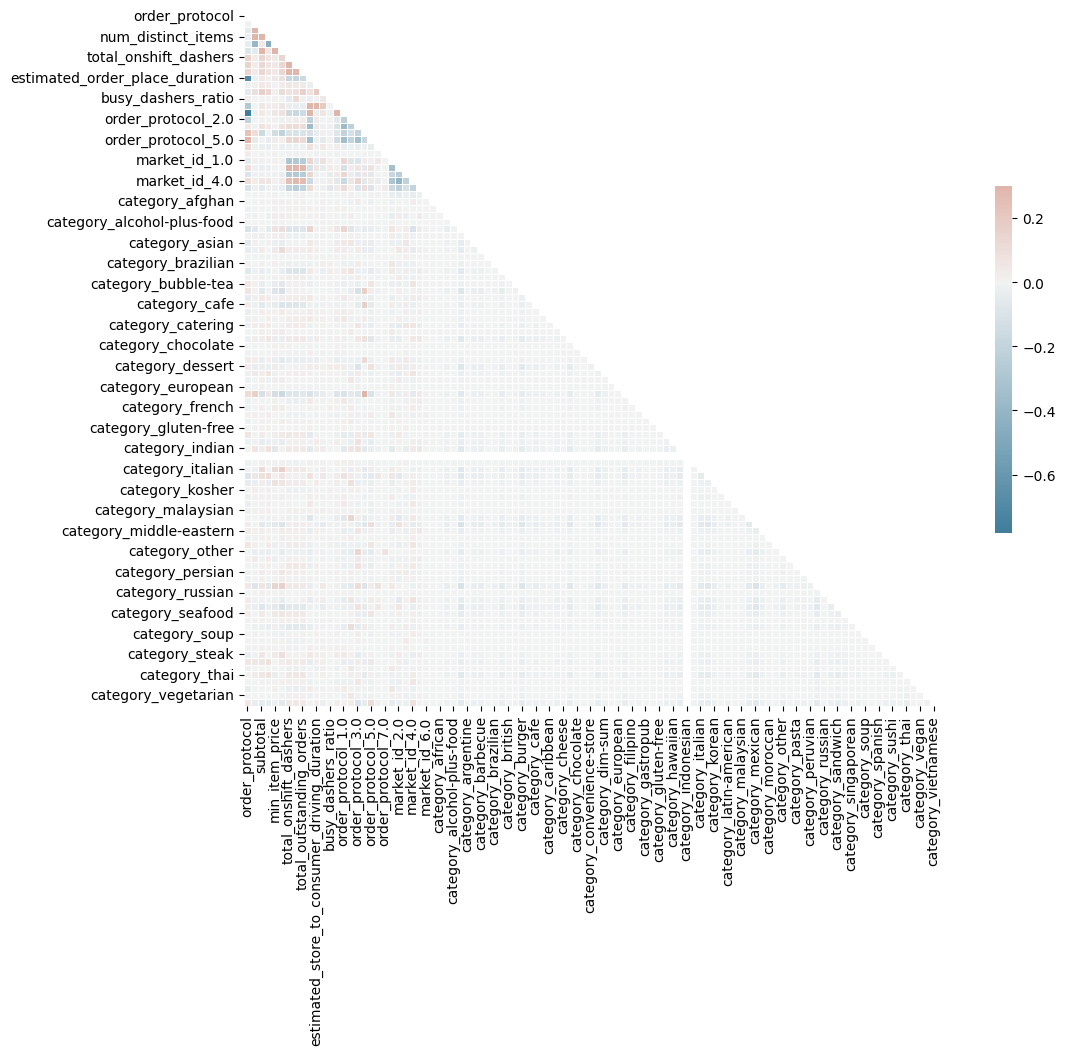

In [26]:
# Setup matplotlib figure
f, ax = plt.subplots(figsize=(15, 9))
# Generate custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


It looks like we have a problem with one of our features, category_indonesioan.

So let’s look closely at it.

In [27]:
train_df['category_indonesian'].describe()

count    176166.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

It has 177,070 zeros, so we can drop this one.

Also, what would have happened if we had not applied the mask? In the below image, you can see two heatmaps. The right one is without the applied mask.

<p align="center" width="200%">
   <img src="images/heatmap.png" width="600">
</p>

### TWO FUNCTIONS TO TEST THE CORRELATIONS

We need to create a function that will help us identify redundant values and find top correlated values.

In [28]:
df.shape
# df.columns

(197428, 20)

Let’s go to the part where we will find redundant pairs by defining a custom function first.

### Finding Redundant Pairs

Here, we will define two functions. The first one helps you create a function that will eventually pair the columns from the DataFrame.

In [29]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]): #iterates over the range 0 to the number of columns
        for j in range(0, i+1): #for each iteration of the loop it will return a pair (current column, to every other column)
            pairs_to_drop.add((cols[i], cols[j])) # adds to the SET therefore eliminating the duplicate pairs
    return pairs_to_drop

### Removing Redundant Pairs
The second function is for calculating the correlation. It uses the first function that makes pairs and eventually removes them.

In [30]:
def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [31]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers                0.941755
                                              total_outstanding_orders          0.934653
total_busy_dashers                            total_outstanding_orders          0.931312
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration       0.923067
estimated_order_place_duration                order_protocol_1.0                0.900654
order_protocol                                order_protocol_1.0                0.780826
                                              order_protocol_5.0                0.768999
total_items                                   num_distinct_items                0.757858
order_protocol                                estimated_order_place_duration    0.687007
subtotal                                      num_distinct_items                0.682964
total_items                                   subtotal                          0.55

## Concatenate With The Dummies

We worked with the numerical features to find the correlation. Now, we will merge our numerical features with the dummy variables, but here we will use the iterative method to find the best model to avoid correlation.

First, let’s don’t concat order_protocol_dummies from all dummy DataFrames. After that, we will look at the rows of our data frame.

Drop features the we used to create dummy variables and other features

In [32]:
train_df = df.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', "actual_delivery_time", "order_protocol", "nan_free_store_primary_category"])

In [33]:
#concatenate our dummy variables excluding market_id dummy because of it having high correlation value across different market_ids
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)

#drop highly correlated features
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian', 'estimated_non_prep_duration'])

#align datatype over dataset
train_df = train_df.astype('float32')
#replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
train_df.shape

(177070, 90)

### Correlated features
Now, let’s rerun our custom function

In [35]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

### Concatenate again
Now, let’s concatenate the dummies without adding order_protocl_dummies.

In [36]:
train_df = df.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', "actual_delivery_time", "order_protocol", "nan_free_store_primary_category"])
#concatenate our dummy variables excluding market_id dummy because of it having high correlation value across different market_ids
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)

#drop highly correlated features
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian', 'estimated_non_prep_duration'])

#align datatype over dataset
train_df = train_df.astype('float32')
#replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

### Create New Features To Overcome The Multicollinearity Issues
Alright, it looks like we still have a problem. Let’s try to create a new variable, which might help us overcome this problem.

**Feature Engineering**

We will create new features from existing features to overcome correlation

In [38]:
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items']/train_df['total_items']
train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df.drop(columns=['num_distinct_items', 'subtotal'], inplace=True)

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

In [39]:
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=['max_item_price', 'min_item_price'], inplace=True)

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.15

Okay, now we have solved the problem with correlation. Now, let’s look at the shape of our data frame again

In [40]:
train_df.shape

(177070, 82)

## Part 3: Multicollinearity and Feature Selection

### Multicollinearity
In order to improve the interpretability and avoid overfitting in our regression analysis, it is important to solve the multicollinearity issue between our columns, which we will use for making predictions.

Multicollinearity happens when your variables are correlated with each other, making it more difficult to evaluate the results of the model and may lead to other issues.

### Multicollinearity Check with VIF
To find out the multicollinearity, we will develop the Variance Inflation Factor(VIF) method.  VIF measures how much the collinearity of a variable affects your regression model. We will remove any features with a VIF score above 20, as it shows a high level of multicollinearity.

To apply that process, we will create a custom function that calculates the VIF scores for each feature in our data frame. Then we will sort the values and create two columns that contain the feature names and corresponding VIF scores.



In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [42]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factore() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=["VIF"]).reset_index(drop=True)

#### Compute VIF Over the DataFrame
Now, let’s apply the VIF computation to all columns.

In [43]:
#apply VIF computation to all columns
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000498
2,category_belgian,1.000760
3,category_russian,1.003231
4,category_african,1.003823
...,...,...
76,busy_dashers_ratio,6.369601
77,category_american,7.033604
78,estimated_store_to_consumer_driving_duration,7.210845
79,estimated_order_place_duration,13.472278


#### Dropping The Features
In this step, we will drop the highest VIF score by writing the while loop. It will first define the highest VIF features and then remove them

In [44]:
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print(f"I will remove {highest_vif_feature}")
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF >20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000369
2,category_belgian,1.000461
3,category_russian,1.002022
4,category_gluten-free,1.002372
...,...,...
75,category_american,4.505928
76,avg_price_per_item,5.958972
77,busy_dashers_ratio,6.357889
78,estimated_store_to_consumer_driving_duration,7.192644


### Feature Selection
Feature selection is the process of identifying and removing redundant features from our data frame in order to improve the performance of a machine learning model.

There are many reasons why this is important. Primarily, it reduces the dimensionality of the DataFrame, which will help our algorithms work faster.

We will focus on two different methods to do that. The first one is Gini’s importance.

But before explaining this, let’s restart the procedure where we select our features and split them into test and training data.

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = train_df[selected_features]
y=train_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)



In [46]:
# doordash_model = RandomForestRegressor()
# doordash_model.fit(X_train, X_test, y_train, y_test)
X.shape


(177070, 80)

### Gini-Importance
Here comes the tricky part. Let’s first learn what the Gini importance is. A Random Forest Regression allows us to measure the importance of our features by using the Gini importance, which calculates the importance of the features across all splits made by random forest regressor. Interesting, right?

Here, we will calculate the importance of each feature in our DataFrame and store the feature names and their importance values in a dictionary. That’s how we will select from the fraction of our DataFrame while applying the machine learning model in the next steps. Here is the code to do that.

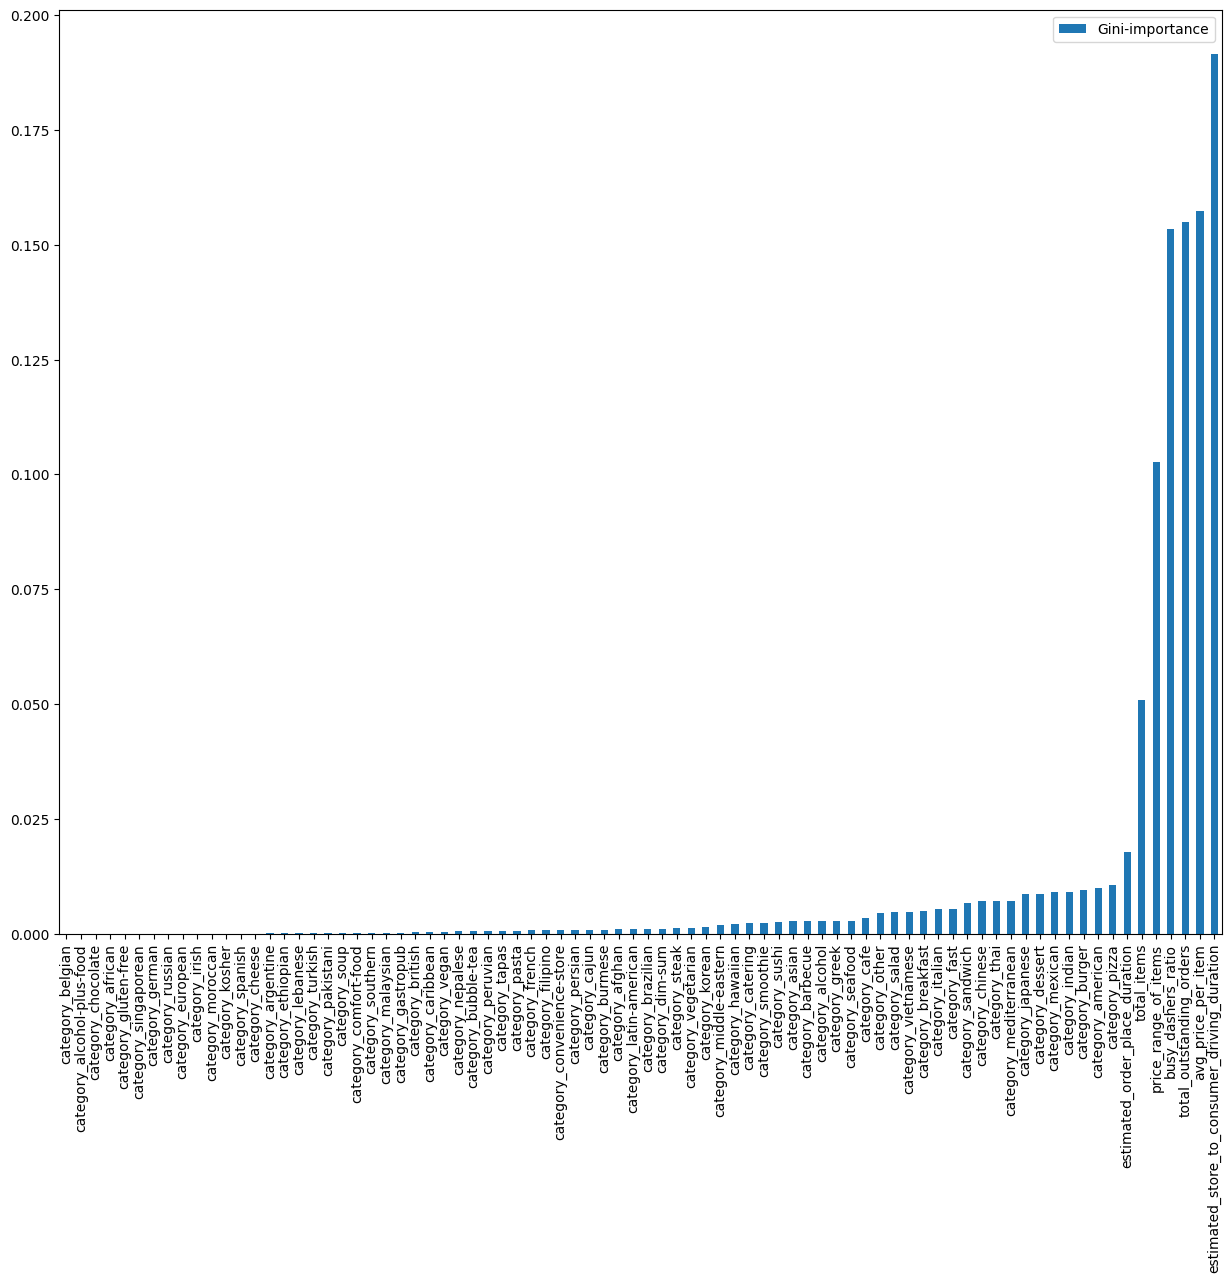

In [47]:
feature_names = [f'feature {i}' for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold a feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance # add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# sort by gini importance 
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

#### Selects by Gini Importance
Here, you can see that we can also find the list as a text.

Here is the code.



In [48]:
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

### PCA
Principle component analysis is a technique for reducing the dimensionality of a DataFrame by identifying and removing redundant features. It is a common technique to reduce dimensionality and eliminate multicollinearity.

By using PCA, we can deduce how many features are needed to explain a certain percentage of the data in our DataFrame. This will help us find the optimum number of features to explain our data frame.

In our case, the goal is to find a way to enhance our model’s performance and improve our algorithm's speed by reducing the number of features from 80 to a more optimal level.

Here is the code to do that. We first import the necessary libraries. And then, we change our feature format, fit, and transform our features and fit it.

Next, we will draw a graph. Here is the code that does that.

/var/folders/vq/ftjkpnkj7g97l89k_f2w4nb00000gn/T/ipykernel_29366/208747704.py:12: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


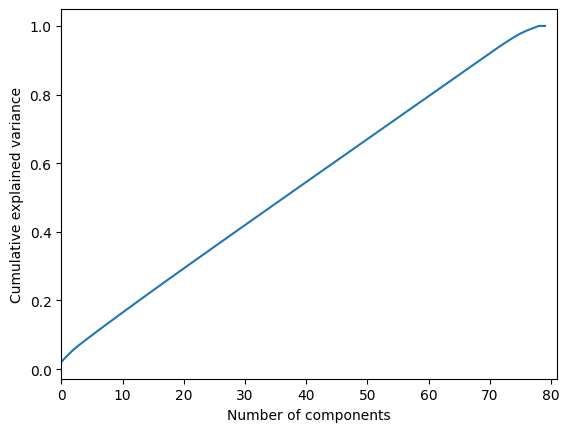

In [49]:
#PCA helps us find optimum number of features for our dataset.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train = X_train.values
X_Train = np.asarray(X_Train)

#Finding normalized array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

We can see that 60 features would explain 80% of our data frame. We already have 80 features, so it is okay. Yet if 10-20 features explain this percentage, we would remove our redundant features.

#### Scaler
In this step, we will define a custom function that will allow us to apply different scalers in our machine-learning process. Scaling is the process of transforming variables to the same scale, which will help our algorithm works faster.

There are two common methods for doing this, Min-Max Scaler and Standard Scaler.

#### Min-Max Scaler
The Min-Max Scaler scales the data between 0 and 1 by subtracting the minimum value and dividing it by the difference between the maximum and minimum values.

#### Standard Scaler
The Standard Scaler scales the data by subtracting the mean and dividing by the standard deviation.

Here is the custom function, which will apply the scaler by its name and transform it.

In [50]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [51]:
def scale(scaler, X, y):
    """Apply the seleced scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled = y_scaler.transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, X_scaler, y_scaler

We will apply this in the next section, let’s see the implementation.

#### Applying Scaler

In [52]:
#example
# X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

# X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

After scaling your data, you should inverse it to make your data the same. A custom function uses inverse_transform() function to do that.

#### Inverse Transform

In [53]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)

    return rmse_error, y_predict

## Part 4: Classical Machine Learning


At this stage, we will follow the iterative process to find the best performance model, which means finding a model that has a lower RMSE error. We will use different models, scalers, and feature sets to do that. Then we will save these results in the list and turn this into a data frame for further analysis.



### Machine Learning Models
Here is a custom function that will fit the models first, then calculate and print the evaluation metrics, train and test error, along with the trained model name with y_predict to then calculate these metrics for all models at once.



In [54]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    model.fit(X_train,y_train)
    y_predict=model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error

In [55]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

We will create pred_dict, which will store regression models, feature sets, scaler names, and RMSE for each model.

In [56]:
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}

Then we will define 6 different regression models starting with Ridge and ending with MLP.

In [57]:
regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(), }

After that, we will create different sets of our features, which are full, 40, 20, and 10. This selection will be made according to Gini's index.

In [58]:
feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(), }

Next, we will have three options in scaler, which are standard, min-max, and without scaler, to see if there might be any difference.

In [59]:
scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

In the final section of our code, we will use three for loops inside each other. These loops take values from the dictionaries we earlier defined and then calculate the RMSE for each of our models and save the result in pred_dict. Also, there is a catch! We wrote the if-else block after loops.

If we apply to scale, we will use inv.transform() function to turn this process back to its original. Why are we doing this?

This is necessary for being able to compare the predictions with the original values and calculate the error between them. The root mean squared error (RMSE) is typically calculated on the original scale, so it is necessary to convert the predictions back to the original scale to be able to calculate the RMSE.

And we will append these results to the lists inside the pred_df dictionary we already defined.



In [60]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are full dataset

Error = 2053.69873046875 in Ridge
Error = 2057.2476687088733 in DecisionTree
Error = 2047.5005944424056 in RandomForest
Error = 2036.2498779296875 in XGBoost
Error = 2033.4355809987908 in LGBM
Error = 2037.9581298828125 in MLP
-----scaled with MinMax scaler-------- included columns are full dataset

Error = 2053.962890625 in Ridge
Error = 2057.2476685732177 in DecisionTree
Error = 2048.273899315941 in RandomForest
Error = 2035.351318359375 in XGBoost
Error = 2034.4499976619875 in LGBM
Error = 2144.31201171875 in MLP
-----scaled with NotScale-------- included columns are full dataset



/Users/fernandes/Desktop/Door-Dash-Project/env2/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.42528e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1071.4970703125 in Ridge
Test error = 2053.692626953125 in Ridge
Train error = 1067.7815291116704 in DecisionTree
Test error = 2057.2476684096064 in DecisionTree
Train error = 397.1019532112445 in RandomForest
Test error = 2049.0214841713255 in RandomForest
Train error = 968.2471313476562 in XGBoost
Test error = 2036.43212890625 in XGBoost
Train error = 1017.5549840201221 in LGBM
Test error = 2034.461097275308 in LGBM


/Users/fernandes/Desktop/Door-Dash-Project/env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1054.4222412109375 in MLP
Test error = 2046.9022216796875 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2054.00439453125 in Ridge
Error = 2056.5292024696128 in DecisionTree
Error = 2048.634707089956 in RandomForest
Error = 2035.453369140625 in XGBoost
Error = 2034.6538984910121 in LGBM
Error = 2035.0740966796875 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_40

Error = 2054.277587890625 in Ridge
Error = 2056.5292023632996 in DecisionTree
Error = 2047.8709354203625 in RandomForest
Error = 2034.2847900390625 in XGBoost
Error = 2035.196536738781 in LGBM
Error = 2101.965576171875 in MLP
-----scaled with NotScale-------- included columns are selected_features_40



/Users/fernandes/Desktop/Door-Dash-Project/env2/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.55922e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1072.35498046875 in Ridge
Test error = 2054.00439453125 in Ridge
Train error = 1067.785563647774 in DecisionTree
Test error = 2056.529202224364 in DecisionTree
Train error = 398.0657258892765 in RandomForest
Test error = 2048.1436294523182 in RandomForest
Train error = 965.6858520507812 in XGBoost
Test error = 2035.7642822265625 in XGBoost
Train error = 1017.1430421117441 in LGBM
Test error = 2034.8058530174258 in LGBM


/Users/fernandes/Desktop/Door-Dash-Project/env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1056.394775390625 in MLP
Test error = 2047.7161865234375 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

Error = 2055.36572265625 in Ridge
Error = 2054.610311207463 in DecisionTree
Error = 2049.4149617124513 in RandomForest
Error = 2037.6336669921875 in XGBoost
Error = 2036.0233846729805 in LGBM
Error = 2037.0447998046875 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_20

Error = 2055.653076171875 in Ridge
Error = 2054.6103112689557 in DecisionTree
Error = 2048.8377808239734 in RandomForest
Error = 2036.5164794921875 in XGBoost
Error = 2035.581516471472 in LGBM
Error = 2119.883544921875 in MLP
-----scaled with NotScale-------- included columns are selected_features_20

Train error = 1074.506591796875 in Ridge
Test error = 2055.36572265625 in Ridge


/Users/fernandes/Desktop/Door-Dash-Project/env2/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.43857e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1069.1350906055598 in DecisionTree
Test error = 2054.610311170708 in DecisionTree
Train error = 395.8291253485156 in RandomForest
Test error = 2049.2795517204568 in RandomForest
Train error = 966.1651000976562 in XGBoost
Test error = 2036.249267578125 in XGBoost
Train error = 1018.9600610110249 in LGBM
Test error = 2035.9494403356318 in LGBM


/Users/fernandes/Desktop/Door-Dash-Project/env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1057.975830078125 in MLP
Test error = 2048.607666015625 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 2056.568359375 in Ridge
Error = 2054.5971761770547 in DecisionTree
Error = 2053.0194849093145 in RandomForest
Error = 2040.27001953125 in XGBoost
Error = 2038.1313604554389 in LGBM
Error = 2040.117919921875 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_10

Error = 2056.88232421875 in Ridge
Error = 2054.5971762373274 in DecisionTree
Error = 2052.8135884848057 in RandomForest
Error = 2039.515625 in XGBoost
Error = 2037.6564489201091 in LGBM
Error = 2093.711181640625 in MLP
-----scaled with NotScale-------- included columns are selected_features_10

Train error = 1076.7279052734375 in Ridge
Test error = 2056.568359375 in Ridge
Train error = 1069.2324011708552 in DecisionTree
Test error = 2054.597176140608 in DecisionTree
Train error = 403.29338265197515 in RandomForest
Test error = 20

/Users/fernandes/Desktop/Door-Dash-Project/env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1061.3543701171875 in MLP
Test error = 2051.86572265625 in MLP


Now, we will use these structures more than once. That’s because most machine learning projects need these iterative processes to find the best performance model.

Now let’s create a DataFrame by using the pandas DataFrame() function to analyze our results further.

In [61]:
pred_df = pd.DataFrame(pred_dict)
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,2053.698730
1,DecisionTree,full dataset,Standard scaler,2057.247669
2,RandomForest,full dataset,Standard scaler,2047.500594
3,XGBoost,full dataset,Standard scaler,2036.249878
4,LGBM,full dataset,Standard scaler,2033.435581
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2093.711182
68,RandomForest,selected_features_10,NotScale,2093.711182
69,XGBoost,selected_features_10,NotScale,2093.711182
70,LGBM,selected_features_10,NotScale,2093.711182


### Plotting Results
Now, to see the results better, let’s visualize them.

<Axes: >

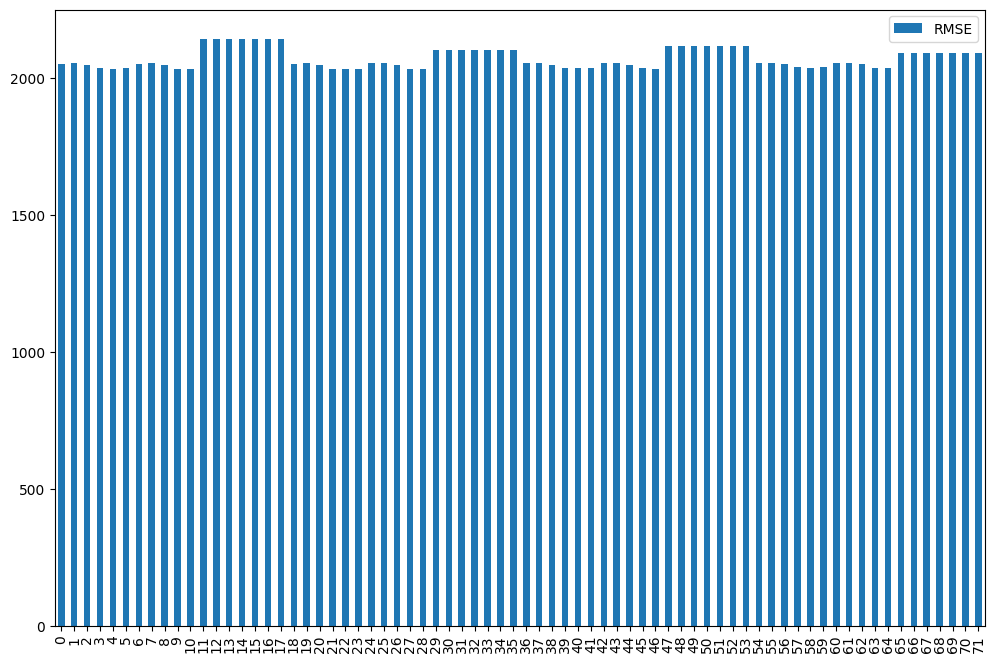

In [62]:
pred_df.plot(kind='bar', figsize=(12,8))

It looks like we have high errors in all our models. Also, the models tell us that not scaling made our model worse, so we will select one of our scalers. When we decrease the feature size, the model performance increases, but after 40, it continues decreasing, so we will select 40 features for our model.

### Changing The Frame
There’s still room for improvement. Let’s change the problem a little bit by predicting prep duration first.

Then we will calculate "actual_total_delivery_duration” after the prediction.

To do that, we have to subtract store_to_consumer_driving_duration and order_to_place_duration from the actual_total_delivery_duration to find prep_duration_pred.

Prep_duration_pred= (actual total delivery duration) - (store to consumer driving duration) -(order to place duration).

After that, we will repeat the whole process, but we will select only 40 features and a standard scaler. So we will have 6 different predictions. Let’s see the code.

In [63]:
train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
       
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2055.40771484375 in Ridge
Error = 2045.9600605629953 in DecisionTree
Error = 2049.949811126268 in RandomForest
Error = 2037.8203125 in XGBoost
Error = 2035.7236370573405 in LGBM
Error = 2038.1575927734375 in MLP


It looks like LGBM outperforms our remaining models every time so we will continue with that.

Here is the code.

In [64]:
# not scaling affects the performance, so continue to scale, but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

regression_models = {
    "LGBM": LGBMRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2035.7236370573405 in LGBM


### Extract Predictions
Now, let’s define a dictionary to choose the best-performance model and extract the prep_duration predictions.

It contains the actual_total_delivery_duration, estimated_store_to_consumer_driving_duration,  and estimated_order_place_duration by using our indices.

Then we will also add prep_duration_prediction by using y_pred.

In [65]:
pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(), 
    "prep_duration_prediction":y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),             
}

Now it’s time to convert that dictionary into a DataFrame. We will find sum_total_delivery_duration after this step.

We will also find an error by using the mean_squared_error() method. It needs an array to make the calculation.

In [66]:
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


Since we already made this calculation earlier, we should turn this back by adding estimated_store_to_consumer_driving_duration and estimated_order_place_duration to prep_duration_prediction to find sum_total_delivery_duration. After that, let’s see our DataFrame.

In [67]:
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


Let’s calculate the mean squared error.

In [68]:
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

2035.7236370573405

We still have a high level of errors. Let’s change the frame one last time. Here we will use prep_duration_prediction, estimated_store_to_consumer_driving_duration, and estimated_order_place_duration to predict actual_total delivery_duration. Do not forget to split your data again

In [69]:
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Alright, now let’s apply the models.

In [70]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))



RMSE of: LinearReg 986.6912510303844
RMSE of: Ridge 986.6912510344928
RMSE of: DecisionTree 1235.578088153976
RMSE of: RandomForest 1268.6547221792232
RMSE of: XGBoost 1370.412425918564
RMSE of: LGBM 1079.2949179771774
RMSE of: MLP 987.9900881052764


As we can see from the output, our error rate drops by nearly half. This model’s performance is better than our other results. So, that may be our solution.

## Deep Learning
Now, as a final step, let’s find out if we would have better results by using a neural network. Let’s create a function using both Keras and TensorFlow to build a model that can predict the actual total delivery time. Our model will be a sequential model with dense layers, using the relu and linear activation functions. We will use the Stochastic Gradient Descent optimizer and the Mean Squared Error loss function, and we will also calculate the root mean squared error.

In [73]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

def create_model(feature_set_size):
    
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    

    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

2023-07-30 15:47:40.765784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we will call our function.

In [74]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
443/443 [==============================] - 2s 3ms/step - loss: 1.1483 - root_mean_squared_error: 1.0716
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1214 - root_mean_squared_error: 1.0589
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1194 - root_mean_squared_error: 1.0580
Epoch 4/100
443/443 [==============================] - 2s 3ms/step - loss: 1.1192 - root_mean_squared_error: 1.0579
Epoch 5/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1188 - root_mean_squared_error: 1.0578
Epoch 6/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1189 - root_mean_squared_error: 1.0578
Epoch 7/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1186 - root_mean_squared_error: 1.0576
Epoch 8/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1183 - 

Now, the error level is not much different than our machine learning models.

Let’s draw a graph to show the relationship between the epoch and loss. Also, an epoch refers to one cycle through the entire data frame, and the loss measures the differences between the actual values and the predicted ones across the entire data frame.

Here is the code.

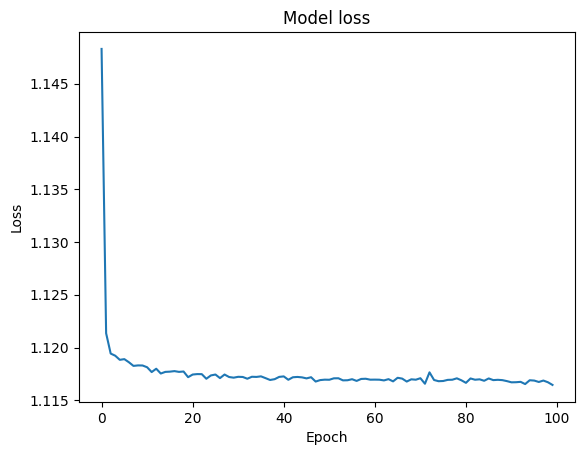

In [75]:
plt.plot(history.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.show()

Based on these results, it seems that linear regression and LGBM will be our best solutions. Yet we could potentially achieve better results by fine-tuning the hyperparameters with various methods. However, considering the time and effort involved, this model is also promising and efficient.

Conclusion
In this data project, the goal was to predict the total delivery duration of food orders placed on DoorDash, a company for ordering food online and delivering it to the customers’ location.

Timely delivery is important for both customers and businesses. By accurately predicting delivery times, DoorDash can improve customer satisfaction. We divided the problem into four sections. We discussed data preparation and modeling in the first section, including feature creation and engineering. Then, we removed redundant and collinear features in section two by using a heatmap.

In section three, we checked multicollinearity by using the VIF score, and then we did feature selection with PCA and Gini’s index.

Finally, we created both Machine Learning and Deep Learning models in the last section.

In the Machine Learning section, we applied 6 different regression algorithms on 4 different feature sets with 3 different scalers, so we got 72 results. Also, we reframed the problem many times by changing the predictors and predicted values. After that, we built a neural net by using the sequential model with dense layers and many other parameters to optimize our model.